# LeR with Custom Functions and Parameters

This notebook is created by [Phurailatpam Hemantakumar](https://hemantaph.com)

[![Documentation](https://img.shields.io/badge/ler-documentation-blue)](https://ler.hemantaph.com)

This notebook demonstrates how to customize the `LeR` class by defining custom source priors, lens parameter samplers, and detection criteria. We'll simulate both unlensed and lensed binary neutron star (BNS) events with fully custom configurations, then compare the results with default models.

---

## Table of Contents
- [1. LeR initialization code snippet with its default input arguments](#1.-LeR-initialization-code-snippet-with-its-default-input-arguments)
- [2. Custom Function Definitions](#2-custom-function-definitions)
   - [2.1 Custom Source Priors](#21-custom-source-priors)
   - [2.2 Custom Lens Parameter Samplers](#22-custom-lens-parameter-samplers)
   - [2.3 Custom Detection Criteria](#23-custom-detection-criteria)
- [3. Initialize LeR with Custom Functions](#3-initialize-ler-with-custom-functions)
   - [3.1 LeR Initialization](#31-ler-initialization)
   - [3.2 Simulate Unlensed Population](#32-simulate-unlensed-population)
   - [3.3 Simulate Lensed Population](#33-simulate-lensed-population)
   - [3.4 Calculate Rates](#34-calculate-rates)
- [4. Compare Custom vs Default Models](#4-compare-custom-vs-default-models)
   - [4.1 Mass Distribution Comparison](#41-mass-distribution-comparison)
   - [4.2 Axis-Ratio Distribution Comparison](#42-axis-ratio-distribution-comparison)

---

## LeR initialization 

### Code snippet for initialization with default input arguments

```python
from ler.rates import LeR
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=0.0, Neff=3.04, m_nu=None, Ob0=0.0)

# Uncomment the below code if you need to change the default arguments.
ler = LeR(
    # LeR setup arguments
    npool=4, # number of processors to use
    z_min=0.0, # minimum redshift
    z_max=10.0, # maximum redshift
    event_type='BBH', # event type
    lens_type = 'epl_shear_galaxy', # lens type
    cosmology=cosmo, # cosmology
    pdet_finder=None,  # if None, the pdet_finder will be calculated using the gwsnr package. 
    list_of_detectors=None, # list of detectors that will be considered when calculating snr or pdet for lensed events. if None, all the detectors from 'gwsnr' will be considered
    json_file_names=dict(
        ler_params="ler_params.json", # to store initialization parameters and important results
        unlensed_param="unlensed_param.json", # to store all unlensed events
        unlensed_param_detectable="unlensed_param_detectable.json", # to store only detectable unlensed events
        lensed_param="lensed_param.json", # to store all lensed events 
        lensed_param_detectable="lensed_param_detectable.json"), # to store only detectable lensed events
    interpolator_directory='./interpolator_json', # directory to store the interpolator pickle files. 'ler' uses interpolation to get values of various functions to speed up the calculations (relying on numba njit).
    ler_directory='./ler_data', # directory to store all the outputs
    verbose=True, # if True, will print all information at initialization

    # CBCSourceParameterDistribution class arguments
    source_priors = dict(
        merger_rate_density = 'merger_rate_density_madau_dickinson_belczynski_ng',
        zs = 'source_redshift',
        source_frame_masses = 'binary_masses_BBH_powerlaw_gaussian',
        geocent_time = 'sampler_uniform',
        ra = 'sampler_uniform',
        dec = 'sampler_cosine',
        phase = 'sampler_uniform',
        psi = 'sampler_uniform',
        theta_jn = 'sampler_sine',
        a_1 = 'sampler_uniform',
        a_2 = 'sampler_uniform',
    ),
    source_priors_params= dict(
        merger_rate_density = dict(R0=19e-9, alpha_F=2.57, beta_F=5.83, c_F=3.36),
        zs = None,
        source_frame_masses = dict(mminbh=4.98, mmaxbh=112.5, alpha=3.78, mu_g=32.27, sigma_g=3.88, lambda_peak=0.03, delta_m=4.8, beta=0.81),
        geocent_time = dict(xmin=1238166018, xmax=1269702018),
        ra = dict(xmin=0.0, xmax=6.283185307179586),
        dec = None,
        phase = dict(xmin=0.0, xmax=6.283185307179586),
        psi = dict(xmin=0.0, xmax=3.141592653589793),
        theta_jn = None,
        a_1 = dict(xmin=-0.8, xmax=0.8),
        a_2 = dict(xmin=-0.8, xmax=0.8),
    ),
    spin_zero= True, # if True, spins will be set to zero
    spin_precession= False, # if True, spins will be precessing

    # LensGalaxyParameterDistribution class arguments
    lens_functions = dict(
        param_sampler_type = 'sample_all_routine_epl_shear_sl',
        cross_section_based_sampler = 'importance_sampling_with_cross_section',
        optical_depth = 'optical_depth_numerical',
        cross_section = 'cross_section_epl_shear_interpolation',
    ),
    lens_functions_params = dict(
        param_sampler_type = None,
        cross_section_based_sampler = dict(n_prop=200),
        optical_depth = None,
        cross_section = None,
    ),
    lens_param_samplers = dict(
        source_redshift_sl = 'strongly_lensed_source_redshifts',
        lens_redshift = 'lens_redshift_strongly_lensed_numerical',
        velocity_dispersion = 'velocity_dispersion_ewoud',
        axis_ratio = 'axis_ratio_rayleigh',
        axis_rotation_angle = 'axis_rotation_angle_uniform',
        external_shear = 'external_shear_normal',
        density_profile_slope = 'density_profile_slope_normal',
        external_shear_sl = 'external_shear_normal',
        density_profile_slope_sl = 'density_profile_slope_normal',
    ),
    lens_param_samplers_params = dict(
        source_redshift_sl = None,
        lens_redshift = dict(integration_size=20000),
        velocity_dispersion = dict(sigma_min=100.0, sigma_max=400.0, alpha=0.94, beta=1.85, phistar=2.099e-2 * (self.cosmo.h / 0.7) ** 3, sigmastar=113.78),
        axis_ratio = dict(q_min=0.2, q_max=1.0),
        axis_rotation_angle = dict(phi_min=0.0, phi_max=6.283185307179586),
        external_shear = dict(mean=0.0, std=0.05),
        density_profile_slope = dict(mean=1.99, std=0.149),
        external_shear_sl = dict(mean=0.0, std=0.05),
        density_profile_slope_sl = dict(mean=2.078, std=0.16),
    ),

    # ImageProperties class arguments
    n_min_images = 2,
    n_max_images = 4,
    time_window = 630720000,
    lens_model_list = ['EPL_NUMBA', 'SHEAR'],

    # gwsnr package arguments
    snr_method = 'interpolation_aligned_spins',
    snr_type = 'optimal_snr',
    gwsnr_verbose = True,
    multiprocessing_verbose = True,
    pdet_kwargs = dict(
        snr_th = 10.0,
        snr_th_net = 10.0,
        pdet_type = 'boolean',
        distribution_type = 'noncentral_chi2',
        include_optimal_snr = False,
        include_observed_snr = False,
    ),
    mtot_min = 9.96,
    mtot_max = 500.0,
    ratio_min = 0.1,
    ratio_max = 1.0,
    spin_max = 0.99,
    mtot_resolution = 200,
    ratio_resolution = 20,
    spin_resolution = 10,
    batch_size_interpolation = 1000000,
    interpolator_dir = './interpolator_json',
    sampling_frequency = 2048.0,
    waveform_approximant = 'IMRPhenomD',
    frequency_domain_source_model = 'lal_binary_black_hole',
    minimum_frequency = 20.0,
    reference_frequency = None,
    duration_max = None,
    duration_min = None,
    fixed_duration = None,
    mtot_cut = False,
    psds = None,  # will consider the default bilby psds of 'L1', 'H1', 'V1'
    ifos = None,  # will consider the default bilby interferometer objects of 'L1', 'H1', 'V1'

    # common arguments, to generate interpolator
    create_new_interpolator = dict(
        merger_rate_density = dict(create_new=False, resolution=500),
        redshift_distribution = dict(create_new=False, resolution=500),
        luminosity_distance = dict(create_new=False, resolution=500),
        differential_comoving_volume = dict(create_new=False, resolution=500),
        source_frame_masses = dict(create_new=False, resolution=500),
        geocent_time = dict(create_new=False, resolution=500),
        ra = dict(create_new=False, resolution=500),
        dec = dict(create_new=False, resolution=500),
        phase = dict(create_new=False, resolution=500),
        psi = dict(create_new=False, resolution=500),
        theta_jn = dict(create_new=False, resolution=500),
        a_1 = dict(create_new=False, resolution=500),
        a_2 = dict(create_new=False, resolution=500),
        tilt_1 = dict(create_new=False, resolution=500),
        tilt_2 = dict(create_new=False, resolution=500),
        phi_12 = dict(create_new=False, resolution=500),
        phi_jl = dict(create_new=False, resolution=500),
        velocity_dispersion = dict(create_new=False, resolution=500, zl_resolution=48),
        axis_ratio = dict(create_new=False, resolution=500, sigma_resolution=48),
        lens_redshift = dict(create_new=False, resolution=48, zl_resolution=48),
        lens_redshift_intrinsic = dict(create_new=False, resolution=500),
        optical_depth = dict(create_new=False, resolution=48),
        comoving_distance = dict(create_new=False, resolution=500),
        angular_diameter_distance = dict(create_new=False, resolution=500),
        angular_diameter_distance_z1z2 = dict(create_new=False, resolution=500),
        density_profile_slope = dict(create_new=False, resolution=100),
        lens_parameters_kde_sl = dict(create_new=False, resolution=5000),
        cross_section = dict(create_new=False, resolution=[25, 25, 45, 15, 15]),
        gwsnr = False,
    )
)
```

### Initialize LeR with default settings

Set `verbose=False` to suppress lengthy output

In [1]:
from ler import LeR
import numpy as np

ler = LeR(verbose=False)


Initializing LeR class...



---

## Examine Available Prior Functions

There are two ways of accessing the built-in GW parameter prior functions and their default parameters. 

### Accessing functions as Class Attributes (Unlensed)

In [2]:
# Display all available GW prior sampler functions and their parameters
print("Built-in GW parameter sampler functions and parameters:\n")
for func_name, func_params in ler.available_gw_prior.items():
    print(f"{func_name}:")
    
    if isinstance(func_params, dict):
        for param_name, param_value in func_params.items():
            print(f"  {param_name}: {param_value}")
    else:
        print(f"  {func_params}")
    print()

Built-in GW parameter sampler functions and parameters:

merger_rate_density:
  merger_rate_density_bbh_oguri2018: {'R0': 1.9e-08, 'b2': 1.6, 'b3': 2.1, 'b4': 30}
  merger_rate_density_madau_dickinson2014: {'R0': 1.9e-08, 'a': 0.015, 'b': 2.7, 'c': 2.9, 'd': 5.6}
  merger_rate_density_madau_dickinson_belczynski_ng: {'R0': 1.9e-08, 'alpha_F': 2.57, 'beta_F': 5.83, 'c_F': 3.36}
  sfr_with_time_delay: {'R0': 1.9e-08, 'a': 0.01, 'b': 2.6, 'c': 3.2, 'd': 6.2, 'td_min': 0.01, 'td_max': 10.0}
  merger_rate_density_bbh_popIII_ken2022: {'R0': 1.92e-08, 'aIII': 0.66, 'bIII': 0.3, 'zIII': 11.6}
  merger_rate_density_bbh_primordial_ken2022: {'R0': 4.4e-11, 't0': 13.786885302009708}

zs:
  source_redshift: None

source_frame_masses:
  binary_masses_BBH_powerlaw_gaussian: {'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81}
  binary_masses_BBH_popIII_lognormal: {'m_min': 5.0, 'm_max': 150.0, 'Mc': 30.0, 'sigma': 0.3}
  bi

### Testing source realted parameter prior functions

In [3]:
# use the following code to inspect one of the merger rate density function
# print(ler.merger_rate_density_bbh_oguri2018.__doc__)

# Test one of the merger rate density function
print("\nTesting merger_rate_density_bbh_oguri2018 function")
zs =  np.array([0.1, 0.2, 0.3])
print(f"Redshifts: {zs}")
print(f"Merger Rate Denisty: {ler.merger_rate_density_bbh_oguri2018(zs)} Mpc^-3 yr^-1")


Testing merger_rate_density_bbh_oguri2018 function
Redshifts: [0.1 0.2 0.3]
merger_rate_density_bbh_oguri2018 interpolator will be loaded from ./interpolator_json/merger_rate_density/merger_rate_density_bbh_oguri2018_4.json
Merger Rate Denisty: [2.21298914e-08 2.57321630e-08 2.98600744e-08] Mpc^-3 yr^-1


### Accessing functions as Class Attributes (Lensed)

In [10]:
# Display all available lens parameter sampler functions and their parameters
print("Built-in lens parameter sampler functions and parameters:\n")
for func_name, func_params in ler.available_lens_samplers.items():
    print(f"{func_name}:")
    
    if isinstance(func_params, dict):
        for param_name, param_value in func_params.items():
            print(f"  {param_name}: {param_value}")
    else:
        print(f"  {func_params}")
    print()

Built-in lens parameter sampler functions and parameters:

source_redshift_sl:
  strongly_lensed_source_redshifts: None

lens_redshift:
  lens_redshift_strongly_lensed_sis_haris: None
  lens_redshift_strongly_lensed_numerical: {'integration_size': 25000, 'use_multiprocessing': False}
  lens_redshift_strongly_lensed_hemanta: None

velocity_dispersion:
  velocity_dispersion_gengamma: {'sigma_min': 100.0, 'sigma_max': 400.0, 'alpha': 0.94, 'beta': 1.85, 'phistar': np.float64(0.02099), 'sigmastar': 113.78}
  velocity_dispersion_choi: {'sigma_min': 100.0, 'sigma_max': 400.0, 'alpha': 2.32, 'beta': 2.67, 'phistar': np.float64(0.0027439999999999995), 'sigmastar': 161.0}
  velocity_dispersion_bernardi: {'sigma_min': 100.0, 'sigma_max': 400.0, 'alpha': 0.94, 'beta': 1.85, 'phistar': np.float64(0.02099), 'sigmastar': 113.78}
  velocity_dispersion_ewoud: {'sigma_min': 100.0, 'sigma_max': 400.0, 'alpha': 0.94, 'beta': 1.85, 'phistar': np.float64(0.02099), 'sigmastar': 113.78}

axis_ratio:
  axis_r

In [ ]:
# use the following code to inspect one of the velocity dispersion sampler functions
# print(ler.velocity_dispersion_gengamma.__doc__)

# Test one of the velocity dispersion sampler functions
print("\nTesting velocity_dispersion_gengamma sampler function")
size = 5
print(f"Velocity dispersion: {ler.velocity_dispersion_gengamma(size)} km/s")


Testing velocity_dispersion_gengamma function
velocity_dispersion_gengamma interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_gengamma_2.json
Velocity dispersion: [179.63602901 145.22139721 115.70296045 106.18811337
 173.48569098] km/s


### Accessing functions from the ler.gw_source_population module (Unlensed)

In [6]:
import ler.gw_source_population as gsp

for prior in gsp.available_prior_list():
    print(prior)

merger_rate_density_bbh_oguri2018_function
merger_rate_density_bbh_popIII_ken2022_function
merger_rate_density_madau_dickinson2014_function
merger_rate_density_madau_dickinson_belczynski_ng_function
merger_rate_density_bbh_primordial_ken2022_function
sfr_madau_fragos2017_with_bbh_td
sfr_madau_dickinson2014_with_bbh_td
sfr_madau_fragos2017_with_bns_td
sfr_madau_dickinson2014_with_bns_td
sfr_madau_fragos2017
sfr_madau_dickinson2014
binary_masses_BBH_popIII_lognormal_rvs
binary_masses_BBH_primordial_lognormal_rvs
binary_masses_BNS_bimodal_rvs
binary_masses_NSBH_broken_powerlaw_rvs
binary_masses_BBH_powerlaw_gaussian_rvs


In [7]:
# use the following code to inspect one of the merger rate density function
# print(gsp.merger_rate_density_bbh_oguri2018.__doc__)

# Test one of the merger rate density function
print("\nTesting merger_rate_density_bbh_oguri2018 function")
zs =  np.array([0.1, 0.2, 0.3])
print(f"Redshifts: {zs}")
print(f"Merger Rate Denisty: {gsp.merger_rate_density_bbh_oguri2018_function(zs)} Mpc^-3 yr^-1")


Testing merger_rate_density_bbh_oguri2018 function
Redshifts: [0.1 0.2 0.3]
Merger Rate Denisty: [2.21298914e-08 2.57321630e-08 2.98600744e-08] Mpc^-3 yr^-1


### Accessing functions from the ler.lens_galaxy_population module (Lensed)

In [8]:
import ler.lens_galaxy_population as lgp

for sampler in lgp.available_sampler_list():
    print(sampler)

lens_redshift_strongly_lensed_sis_haris_pdf
lens_redshift_strongly_lensed_sis_haris_rvs
velocity_dispersion_ewoud_denisty_function
velocity_dispersion_bernardi_denisty_function
velocity_dispersion_gengamma_density_function
velocity_dispersion_gengamma_pdf
velocity_dispersion_gengamma_rvs
axis_ratio_rayleigh_rvs
axis_ratio_rayleigh_pdf
axis_ratio_padilla_strauss_rvs
axis_ratio_padilla_strauss_pdf
bounded_normal_sample
rejection_sampler
importance_sampler
importance_sampler_mp


In [ ]:
# use the following code to inspect one of the velocity dispersion sampler functions
# print(lgp.velocity_dispersion_gengamma_rvs.__doc__)

# Test one of the velocity dispersion sampler functions
print("\nTesting velocity_dispersion_gengamma sampler function")
size = 5
print(f"Velocity dispersion: {lgp.velocity_dispersion_gengamma_rvs(size)} km/s")


Testing velocity_dispersion_gengamma function
Velocity dispersion: [100.68125009 168.74814017 107.05317212 192.6835846
 120.50682314] km/s


---

## Using Custom Functions in LeR Initialization

The `ler` package allows full customization of sampling functions and detection criteria. This section demonstrates a **Binary Neutron Star (BNS)** configuration with custom settings:

| Component | Custom Configuration | Default (BBH) |
| :--- | :--- | :--- |
| **Event Type** | BNS (non-spinning) | BBH (spinning, aligned) |
| **Merger Rate** | GWTC-3 based | GWTC-4 based |
| **Source Masses** | Uniform 1.0-2.3 $M_{\odot}$ | Bimodal Gaussian |
| **Lens Model** | SIE (Singular Isothermal) | EPL+Shear |
| **Velocity Dispersion** | $\sigma_* = 161$ km/s | $\sigma_* = 113.78$ km/s |
| **Axis Ratio** | Padilla & Strauss (2008) | Rayleigh distribution |
| **Detectors** | 3G (ET, CE), SNR > 12 | O4 (H1, L1, V1), SNR > 10 |

**Notes:**

- **GW parameter sampling priors** and **lens parameter samplers**: Must be a function with `size` as the only input argument, or a `ler.utils.FunctionConditioning` class object (preferred for lens parameters). Use `numba.njit` decorator for prior/sampler functions when possible. `ler.utils.FunctionConditioning` creates interpolators for the custom functions to speed up the calculations relying on numba njit.

- **Merger rate density**: Must be a function of redshift, i.e., $F(z_s)$.

- **Velocity dispersion function (galaxy number density)**: Must be a function of velocity dispersion, i.e., $F(\sigma)$ or $F(\sigma, z_l)$.

### Custom Event Type with non-spining configuration

Using `event_type='BNS'` in the LeR class initialization will default to the following GW parameter priors corresponding to BNS. Other allowed event types are 'BBH' and 'NSBH'.

```python
    source_priors = dict(
        merger_rate_density = 'merger_rate_density_madau_dickinson2014',
        source_frame_masses = 'binary_masses_BNS_bimodal',
        a_1 = 'sampler_uniform',
        a_2 = 'sampler_uniform',
    ),
    source_priors_params= dict(
        merger_rate_density = dict(
            R0=89 * 1e-9, 
            a=0.015, 
            b=2.7, 
            c=2.9, 
            d=5.6,
        ),
        source_frame_masses = dict(
            w=0.643, 
            muL=1.352, 
            sigmaL=0.08, 
            muR=1.88, 
            sigmaR=0.3, 
            mmin=1.0, 
            mmax=2.3,
        ),
        a_1 = dict(xmin=-0.05, xmax=0.05),
        a_2 = dict(xmin=-0.05, xmax=0.05),
    ),
```

We will change some of these priors with our custom ones in the next sections.

For non-spining configuration (for faster calculation in our example), we can set:

```python
    spin_zero=True,
    spin_precession=False,
```

### Custom Merger Rate Density

Using the default BNS merger rate density prior model with the local merger rate density change from the default value of $R_0 = 89 \times 10^{-9} \, \text{Mpc}^{-3}\text{yr}^{-1}$ (GWTC-4) to $R_0 = 105.5 \times 10^{-9} \, \text{Mpc}^{-3}\text{yr}^{-1}$ (GWTC-3).

In [17]:
merger_rate_density_function = 'merger_rate_density_madau_dickinson2014'
merger_rate_density_input_args = dict(
    R0=89e-9, 
    a=0.015, 
    b=2.7, 
    c=2.9, 
    d=5.6,
)

print("Merger rate density function:", merger_rate_density_function)
print("Parameters:", merger_rate_density_input_args)

Merger rate density function: merger_rate_density_madau_dickinson2014
Parameters: {'R0': 8.9e-08, 'a': 0.015, 'b': 2.7, 'c': 2.9, 'd': 5.6}


### Custom Source Frame Masses

Using uniform distribution to smaple the binary masses mass_1 and mass_2. Sawap values if mass_1 < mass_2.

In [18]:
import numpy as np

# define the arguments for the bns bimodal pdf
source_frame_masses_args = dict(
    mmin=1.0, # minimum mass of the black hole (Msun)
    mmax=2.3, # maximum mass of the black hole (Msun)
)

# define your custom function of mass_1_source and mass_2_source calculation
# it should have 'size' as the only argument
def source_frame_masses_uniform(size):
    """
    Function to sample mass1 and mass2 from a powerlaw with a gaussian peak

    Parameters
    ----------
    size : `int`
        Number of samples to draw

    Returns
    -------
    mass_1_source : `numpy.ndarray`
        Array of mass1 samples. 
    mass_2_source : `numpy.ndarray`
        Array of mass2 samples
    """

    mass_1_source = np.random.uniform(source_frame_masses_args['mmin'], source_frame_masses_args['mmax'], size)
    mass_2_source = np.random.uniform(source_frame_masses_args['mmin'], source_frame_masses_args['mmax'], size)
    # swap if mass_2_source > mass_1_source
    idx = mass_2_source > mass_1_source
    mass_1_source[idx], mass_2_source[idx] = mass_2_source[idx], mass_1_source[idx] 

    return (mass_1_source, mass_2_source)

# test
mass_1_source, mass_2_source = source_frame_masses_uniform(size=5)
print(f"mass_1: {mass_1_source} M_sun")
print(f"mass_2: {mass_2_source} M_sun")

mass_1: [2.23567651 1.8713216  1.63706892 2.1271594  1.98181497] M_sun
mass_2: [2.06991154 1.25900846 1.35433734 2.03050001 1.30739588] M_sun


### Custom Lens Model

Using `lens_model='sie_galaxy'` in the `LeR` initialization will use the following settings:

```python
lens_param_samplers = dict(
    source_redshift_sl="strongly_lensed_source_redshifts",
    lens_redshift="lens_redshift_strongly_lensed_numerical",
    velocity_dispersion="velocity_dispersion_ewoud",
    axis_ratio="axis_ratio_rayleigh",
    axis_rotation_angle="axis_rotation_angle_uniform",
    external_shear="external_shear_normal",
    density_profile_slope="density_profile_slope_normal",
    external_shear_sl="external_shear_normal",
    density_profile_slope_sl="density_profile_slope_normal",
)
lens_param_samplers_params = dict(
    source_redshift_sl=None,
    lens_redshift=dict(integration_size=20000),
    velocity_dispersion=dict(
        sigma_min=100.0,
        sigma_max=400.0,
        alpha=0.94,
        beta=1.85,
        phistar=2.099e-2,
        sigmastar=113.78,
    ),
    axis_ratio=dict(q_min=0.2, q_max=1.0),
    axis_rotation_angle=dict(phi_min=0.0, phi_max=2 * np.pi),
    external_shear=dict(mean=0.0, std=0.0),
    density_profile_slope=dict(mean=2.0, std=0.0),
    external_shear_sl=dict(mean=0.0, std=0.0),
    density_profile_slope_sl=dict(mean=2.0, std=0.0),
)
lens_functions = dict(
    param_sampler_type="sample_all_routine_epl_shear_sl",
    cross_section_based_sampler="importance_sampling_with_cross_section",
    optical_depth="optical_depth_numerical",
    cross_section="cross_section_sie_feixu",
)
lens_functions_params = dict(
    param_sampler_type=None,
    cross_section_based_sampler=dict(n_prop=200),
    optical_depth=dict(interpolated_cross_section=True),
    cross_section=None,
)
```

We will change the velocity dispersion and axis ratio samplers to our custom functions.

#### Custom Velocity Dispersion

Unlike other lens parameter, custom velocity dispersion needs to be a density function.

In [31]:
from numba import njit
from ler.lens_galaxy_population import velocity_dispersion_ewoud_denisty_function

velocity_dispersion_args = dict(
    sigma_min=100.,  # default ler sigma_min=100 km/s
    sigma_max=400.,  # default ler sigma_max=400 km/s
    alpha=0.94,
    beta=1.85,
    phistar=2.099e-2,
    sigmastar=161.0,
)
alpha = float(velocity_dispersion_args["alpha"])
beta = float(velocity_dispersion_args["beta"])
phistar = float(velocity_dispersion_args["phistar"])
sigmastar = float(velocity_dispersion_args["sigmastar"])

sigma_object = njit(
    lambda sigma, zl: velocity_dispersion_ewoud_denisty_function(  # noqa: E731
        sigma,
        zl,
        alpha=alpha,
        beta=beta,
        phistar=phistar,
        sigmastar=sigmastar,
    )
)

# Test
sigma = np.array([100., 200., 300.])
zl = np.array([0.1, 0.2, 0.3])
print(f"Velocity dispersions: {sigma} km/s at lens redshifts: {zl}")
print(f"Velocity dispersion density function values: {sigma_object(sigma, zl)} Mpc^-3")

Velocity dispersions: [100. 200. 300.] km/s at lens redshifts: [0.1 0.2 0.3]
Velocity dispersion density function values: [9.75545769e-05 3.09054569e-05 5.78714206e-06] Mpc^-3


Uncomment and run the following if you want to use `ler.utils.FunctionConditioning` class object.

In [27]:
# import numpy as np
# from ler.utils import FunctionConditioning, redshift_optimal_spacing
# # import number density function wrt velocity dispersion and redshift
# from ler.lens_galaxy_population import velocity_dispersion_ewoud_denisty_function

# velocity_dispersion_args = dict(
#     sigma_min=100,  # default ler sigma_min=100 km/s
#     sigma_max=400,  # default ler sigma_max=400 km/s
#     alpha=0.94,
#     beta=1.85,
#     phistar=2.099e-2,
#     sigmastar=161.0,
# )

# # identifier_dict dict allows for easy tracking of the generated interpolator in future usage
# identifier_dict = {"name": "velocity_dispersion_custom"}
# identifier_dict["sigma_min"] = velocity_dispersion_args["sigma_min"]
# identifier_dict["sigma_max"] = velocity_dispersion_args["sigma_max"]
# identifier_dict["resolution"] = 500
# identifier_dict["zl_resolution"] = 48

# # setting up inputs for the interpolator
# # Note: sigma_array and zl_array will form a 2D grid where the function is evaluated. Gird points are use for cubic spline interpolation.
# sigma_array = np.linspace(
#     identifier_dict["sigma_min"],
#     identifier_dict["sigma_max"],
#     identifier_dict["resolution"],
# )
# z_min = 0.001
# z_max = 10.0
# z_resolution = identifier_dict["zl_resolution"]
# zl_array = redshift_optimal_spacing(z_min, z_max, z_resolution)

# # define the function
# number_density_function = lambda sigma, zl: velocity_dispersion_ewoud_denisty_function(  # noqa: E731
#     sigma,
#     zl,
#     alpha=velocity_dispersion_args["alpha"],
#     beta=velocity_dispersion_args["beta"],
#     phistar=velocity_dispersion_args["phistar"],
#     sigmastar=velocity_dispersion_args["sigmastar"],
# )

# sigma_object = FunctionConditioning(
#     function=number_density_function,
#     x_array=sigma_array,
#     conditioned_y_array=zl_array,
#     identifier_dict=identifier_dict,
#     directory="./interpolator_json",
#     sub_directory="velocity_dispersion",
#     name=identifier_dict["name"],
#     create_new=False,
#     create_function_inverse=False,
#     create_function=True,
#     create_pdf=True,
#     create_rvs=True,
#     callback="rvs",
# )

# # Test
# sigma = np.array([100., 200., 300.])
# zl = np.array([0.1, 0.2, 0.3])
# print(f"Velocity dispersions: {sigma} km/s at lens redshifts: {zl}")
# print(f"Velocity dispersion density function values: {sigma_object.function(sigma, zl)} Mpc^-3")
# print(f"Random velocity dispersion samples: {sigma_object.rvs(len(zl), zl)} Mpc^-3")

### Custom Axis Ratio

In [28]:
from scipy.interpolate import CubicSpline  # noqa: E402
from ler.utils import inverse_transform_sampler  # noqa: E402
from numba import njit  # noqa: E402

axis_ratio_args = dict(
    q_min=0.2,
    q_max=1.0,
)

# Using Padilla and Strauss 2008 distribution for axis ratio
q_array = np.array(
    [0.04903276402927845,0.09210526315789469,0.13596491228070173,0.20789473684210524,0.2899703729522482,0.3230132450331126,0.35350877192982455,0.37946148483792264,0.4219298245614036,0.4689525967235971,0.5075026141512723,0.5226472638550018,0.5640350877192983,0.6096491228070177,0.6500000000000001,0.6864848379226213,0.7377192982456142,0.7787295224817011,0.8007581038689441,0.822786685256187,0.8668438480306729,0.8973684210526317,0.9254385964912283,
    ]
)
pdf = np.array(
    [0.04185262687135349,0.06114520695141845,0.096997499638376,0.1932510900336828,0.39547914337673706,0.49569751276216234,0.6154609137685201,0.7182049959882812,0.920153741243567,1.1573982157399754,1.3353263628106684,1.413149656448315,1.5790713532948977,1.7280185150744938,1.8132994441344819,1.8365803753840484,1.8178662203211204,1.748929843583365,1.688182592496342,1.6274353414093188,1.4948487090314488,1.402785526832393,1.321844068356993,
    ]
)

# Interpolate the pdf
spline = CubicSpline(q_array, pdf, extrapolate=True)
q_array = np.linspace(axis_ratio_args['q_min'], axis_ratio_args['q_max'], 500)
pdf = spline(q_array)
cdf_values = np.cumsum(pdf)
cdf_values /= cdf_values[-1] # normalize

q_object = njit(lambda size: inverse_transform_sampler(size, cdf_values, q_array))

# test
q_samples = q_object(5)
print(f"Axis ratio samples: {q_samples}")

Axis ratio samples: [0.53932252 0.76120391 0.31770006 0.64044733 0.835603  ]


Uncomment and run the following if you want to use `ler.utils.FunctionConditioning` class object.

In [29]:
# from scipy.interpolate import CubicSpline  # noqa: E402
# from ler.utils import FunctionConditioning  # noqa: E402

# axis_ratio_args = dict(
#     q_min=0.2,
#     q_max=1.0,
# )

# identifier_dict = {"name": "axis_ratio_padilla_strauss_custom"}
# identifier_dict["q_min"] = axis_ratio_args["q_min"]
# identifier_dict["q_max"] = axis_ratio_args["q_max"]
# identifier_dict["resolution"] = 500

# # Using Padilla and Strauss 2008 distribution for axis ratio
# q_array = np.array(
#     [0.04903276402927845,0.09210526315789469,0.13596491228070173,0.20789473684210524,0.2899703729522482,0.3230132450331126,0.35350877192982455,0.37946148483792264,0.4219298245614036,0.4689525967235971,0.5075026141512723,0.5226472638550018,0.5640350877192983,0.6096491228070177,0.6500000000000001,0.6864848379226213,0.7377192982456142,0.7787295224817011,0.8007581038689441,0.822786685256187,0.8668438480306729,0.8973684210526317,0.9254385964912283,
#     ]
# )
# pdf = np.array(
#     [0.04185262687135349,0.06114520695141845,0.096997499638376,0.1932510900336828,0.39547914337673706,0.49569751276216234,0.6154609137685201,0.7182049959882812,0.920153741243567,1.1573982157399754,1.3353263628106684,1.413149656448315,1.5790713532948977,1.7280185150744938,1.8132994441344819,1.8365803753840484,1.8178662203211204,1.748929843583365,1.688182592496342,1.6274353414093188,1.4948487090314488,1.402785526832393,1.321844068356993,
#     ]
# )

# # Interpolate the pdf
# spline = CubicSpline(q_array, pdf, extrapolate=True)
# q_array = np.linspace(identifier_dict["q_min"], identifier_dict["q_max"], identifier_dict["resolution"])
# pdf = spline(q_array)

# q_object = FunctionConditioning(
#     function=pdf,  # it also allows precomputed values, besides function
#     x_array=q_array,
#     conditioned_y_array=None,
#     identifier_dict=identifier_dict,
#     directory="./interpolator_json",
#     sub_directory="axis_ratio",
#     name="axis_ratio_padilla_strauss",
#     create_new=False,
#     create_function_inverse=False,
#     create_function=True,
#     create_pdf=True,
#     create_rvs=True,
#     callback="rvs",
# )

# # test
# # sampling
# q_samples = q_object.rvs(5)
# print(f"Axis ratio samples: {q_samples}")
# # pdf
# q_pdf = q_object.pdf(q_samples)
# print(f"Axis ratio pdf values: {q_samples}")

### Custom Detection Criteria

Define a custom pdet_finder using 3G detectors (Einstein Telescope and Cosmic Explorer) with SNR threshold of 12.

In [38]:
# Define a function that sets detection criteria
from gwsnr import GWSNR

# 3G detectors: Einstein Telescope (ET) and Cosmic Explorer (CE)
mmin, mmax = 1.0, 2.3
zmin, zmax = 0.0, 10.0

gwsnr_3g = GWSNR(
    npool=4,
    ifos=['ET', 'CE'],  # 3G detector network
    snr_method='interpolation_no_spins',  # BNS have no spins
    mtot_min=2*mmin*(1+zmin), mtot_max=2*mmax*(1+zmax),
    sampling_frequency=2048.0, waveform_approximant='IMRPhenomD',
    minimum_frequency=20.0, gwsnr_verbose=False,
)

def detection_criteria(gw_param_dict, detection_threshold=12):
    """Custom detection criteria for 3G detectors with SNR > 12."""
    dict_ = {}
    dict_.update(gwsnr_3g.optimal_snr(gw_param_dict=gw_param_dict))
    dict_['pdet_net'] = dict_['optimal_snr_net'] > detection_threshold
    return dict_

# test
gw_param_dict = dict(
    mass_1 = np.array([20.0, 20.0]),
    mass_2 = np.array([10.0, 10.0]),
    luminosity_distance = np.array([1000.0, 2000.0]),
)
detection_dict = detection_criteria(gw_param_dict)
print(f"GW parameters: {gw_param_dict}")
print(f"Detection criteria results: {detection_dict}")


Initializing GWSNR class...

Interpolator will be loaded for ET1 detector from ./interpolator_json/ET1/partialSNR_dict_0.json
Interpolator will be loaded for ET2 detector from ./interpolator_json/ET2/partialSNR_dict_0.json
Interpolator will be loaded for ET3 detector from ./interpolator_json/ET3/partialSNR_dict_0.json
Interpolator will be loaded for CE detector from ./interpolator_json/CE/partialSNR_dict_0.json


GW parameters: {'mass_1': array([20., 20.]), 'mass_2': array([10., 10.]), 'luminosity_distance': array([1000., 2000.])}
Detection criteria results: {'optimal_snr_ET1': array([26.4831826, 13.2415913]), 'optimal_snr_ET2': array([75.61201064, 37.80600532]), 'optimal_snr_ET3': array([84.12758283, 42.06379141]), 'optimal_snr_CE': array([391.759156, 195.879578]), 'optimal_snr_net': array([408.62112233, 204.31056117]), 'pdet_net': array([ True,  True])}


### LeR initialization with custom functions and parameters 

Create a `LeR` instance with custom source priors, lens samplers, and detection criteria for BNS events.

In [39]:
from ler import LeR

ler = LeR(
    # Core setup
    npool=6, 
    event_type='BNS', 
    lens_type='sie_galaxy',
    
    # Source priors
    source_priors=dict(
        merger_rate_density=merger_rate_density_function,
        source_frame_masses=source_frame_masses_uniform,
    ),
    source_priors_params=dict(
        merger_rate_density_input_args=merger_rate_density_input_args,
        source_frame_masses=source_frame_masses_args,
    ),
    
    # Lens samplers
    lens_param_samplers=dict(
        velocity_dispersion=sigma_object,
        axis_ratio=q_object,
    ),
    lens_param_samplers_params=dict(
        velocity_dispersion=velocity_dispersion_args,
        axis_ratio=axis_ratio_args,
    ),
    
    # Custom detection
    pdet_finder=detection_criteria,
    ler_directory='./ler_data_custom',
)


Initializing LeR class...


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_json/comoving_distance/comoving_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
angular_diameter_distance interpolator will be loaded from ./interpolator_json/angular_diameter_distance/angular_diameter_distance_0.json
differential_comoving_volume interpolator will be loaded from ./interpolator_json/differential_comoving_volume/differential_comoving_volume_0.json
using user provided custom velocity_dispersion function
velocity_dispersion_custom interpolator will be loaded from ./interpolator_json/velocity_dispersion/velocity_dispersion_custom_4.json
using user provided custom axis_ratio sampler function
using ler available axis_rotation_angle function : axis_rotation_angle_uniform
using ler available d

### Simulate Unlensed Population

Generate unlensed BNS events using the custom mass distribution and merger rate density.

In [47]:
unlensed_params = ler.unlensed_cbc_statistics(size=100000, batch_size=50000, resume=False)

print(f"\nTotal unlensed events simulated: {len(unlensed_params['zs'])}")
print(f"Sample source redshift values (first 5): {unlensed_params['zs'][:5]}")
print(f"Sample masses (first 3):")
print(f"  mass_1: {unlensed_params['mass_1_source'][:3]}")
print(f"  mass_2: {unlensed_params['mass_2_source'][:3]}")

unlensed params will be stored in ./ler_data_custom/new_unlensed_params.json
removing ./ler_data_custom/new_unlensed_params.json if it exists
Batch no. 1
sampling gw source params...
calculating pdet...
Batch no. 2
sampling gw source params...
calculating pdet...
saving all unlensed parameters in ./ler_data_custom/new_unlensed_params.json 

Total unlensed events simulated: 100000
Sample source redshift values (first 5): [2.01592263 2.2300552  4.42895145 2.94937447 3.21781353]
Sample masses (first 3):
  mass_1: [1.45329514 1.96548468 2.24679732]
  mass_2: [1.30105817 1.35028269 1.14193659]


### Simulate Lensed Population

Generate lensed BNS events with custom lens parameters.

In [49]:
lensed_params = ler.lensed_cbc_statistics(size=100000, batch_size=50000, resume=True)

print(f"\nTotal lensed events simulated: {len(lensed_params['zs'])}")
print(f"Sample source redshift values (first 5): {lensed_params['zs'][:5]}")
print(f"Lens parameters (first 3):")
lens_params = ['zl', 'sigma', 'q']
for param in lens_params:
    if param in lensed_params:
        print(f"  {param}: {lensed_params[param][:3]}")

lensed params will be stored in ./ler_data_custom/new_lensed_params.json
resuming from ./ler_data_custom/new_lensed_params.json
lensed parameters already sampled.
saving all lensed parameters in ./ler_data_custom/new_lensed_params.json 

Total lensed events simulated: 100000
Sample source redshift values (first 5): [2.62306545 2.47487797 2.157893   3.27988992 4.03900702]
Lens parameters (first 3):
  zl: [0.54555757 0.30722322 0.86237951]
  sigma: [162.84398628 226.89039305 218.70283461]
  q: [0.69185282 0.76046845 0.57285717]


### Calculate Rates and Compare Results

Calculate unlensed and lensed detection rates using the custom detection criteria.

In [50]:
# Calculate detection rates
rate_unlensed, unlensed_param_detectable = ler.unlensed_rate()
rate_lensed, lensed_param_detectable = ler.lensed_rate()
rate_ratio = ler.rate_ratio()

print(f"\n=== Detection Rates (BNS with Custom Configuration) ===")
print(f"Unlensed rate: {rate_unlensed:.4e} events/year")
print(f"Lensed rate:   {rate_lensed:.4e} events/year")
print(f"Rate ratio (lensed/unlensed): {rate_ratio:.4f}")

Getting unlensed_param from json file ./ler_data_custom/new_unlensed_params.json...
total unlensed rate (yr^-1): 79073.58906999836
number of simulated unlensed detectable events: 23846
number of simulated all unlensed events: 100000
storing detectable params in ./ler_data_custom/unlensed_param_detectable.json
Getting lensed_param from json file ./ler_data_custom/new_lensed_params.json...
total lensed rate (yr^-1): 102.50441798314746
number of simulated lensed detectable events: 8070
number of simulated all lensed events: 100000
storing detectable params in ./ler_data_custom/lensed_param_detectable.json
unlensed_rate: 79073.58906999836
lensed_rate: 102.50441798314746
ratio: 771.4163996619022

=== Detection Rates (BNS with Custom Configuration) ===
Unlensed rate: 7.9074e+04 events/year
Lensed rate:   1.0250e+02 events/year
Rate ratio (lensed/unlensed): 771.4164


---

## Compare Custom vs Default Models

### Mass Distribution Comparison

Compare the custom uniform mass distribution with the default BNS bimodal distribution.

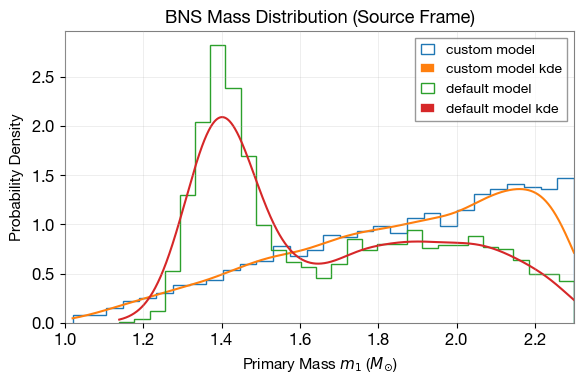

In [57]:
import ler.utils as lerplt
import matplotlib.pyplot as plt

# Compare mass distributions
m1_custom, m2_custom = source_frame_masses_uniform(size=5000)
m1_default, m2_default = ler.binary_masses_BNS_bimodal(size=5000)

custom_dict = dict(mass_1=m1_custom)
default_dict = dict(mass_1=m1_default)

# Plot comparison
plt.figure(figsize=(6, 4))
lerplt.param_plot(
    param_name="mass_1", 
    param_dict=custom_dict, # or the json file name
    plot_label='custom model',
);
lerplt.param_plot(
    param_name="mass_1", 
    param_dict=default_dict,
    plot_label='default model',
);
plt.xlabel(r'Primary Mass $m_1$ ($M_{\odot}$)', fontsize=11)
plt.ylabel(r'Probability Density', fontsize=11)
plt.title('BNS Mass Distribution (Source Frame)', fontsize=13, fontweight='bold')
plt.xlim(1.0, 2.3)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Axis-Ratio Distribution Comparison

Compare the default axis-ratio distribution (Rayleigh distribution, Collet et al. 2018) with custom axis-ratio distribution (Padilla and Strauss 2008)

axis_ratio_rayleigh interpolator will be loaded from ./interpolator_json/axis_ratio/axis_ratio_rayleigh_3.json


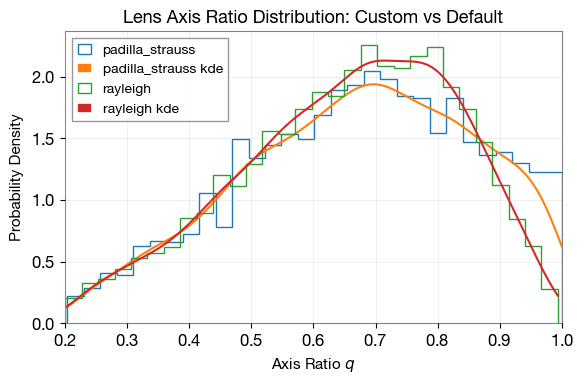

In [61]:
# Compare axis-ratio distributions
size = 5000
zl = np.ones(size)
sigma = ler.velocity_dispersion(size, zl)
rayleigh = ler.axis_ratio_rayleigh(size, sigma)
padilla_strauss = q_object(size)

axis_ratio_dict = dict(rayleigh=rayleigh, padilla_strauss=padilla_strauss)

# Plot comparison
plt.figure(figsize=(6, 4))
lerplt.param_plot(
    param_name="padilla_strauss",
    param_dict=axis_ratio_dict,
    plot_label='padilla_strauss',
)
lerplt.param_plot(
    param_name="rayleigh",
    param_dict=axis_ratio_dict,
    plot_label='rayleigh',
)
plt.xlabel(r'Axis Ratio $q$', fontsize=11)
plt.ylabel(r'Probability Density', fontsize=11)
plt.title('Lens Axis Ratio Distribution: Custom vs Default', fontsize=13, fontweight='bold')
plt.xlim(0.2, 1.)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()